Load data and preprocess

In [1]:
import pandas as pd

In [3]:
df = pd.read_csv("../data/bank-full.csv", sep=";")
df.columns = df.columns.str.lower().str.replace(' ', '_')
df = df[["age", "job", "marital", "education", "balance", "housing", "contact", "day", "month", "duration", "campaign", "pdays", "previous", "poutcome", "y"]]
df.y = (df.y == 'yes').astype(int)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   balance    45211 non-null  int64 
 5   housing    45211 non-null  object
 6   contact    45211 non-null  object
 7   day        45211 non-null  int64 
 8   month      45211 non-null  object
 9   duration   45211 non-null  int64 
 10  campaign   45211 non-null  int64 
 11  pdays      45211 non-null  int64 
 12  previous   45211 non-null  int64 
 13  poutcome   45211 non-null  object
 14  y          45211 non-null  int64 
dtypes: int64(8), object(7)
memory usage: 5.2+ MB


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [6]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)
print(len(df_train), len(df_val), len(df_test))

27126 9042 9043


In [7]:
numerical = list(df.dtypes[df.dtypes == 'int64'].index)
categorical = df.columns[df.dtypes == "object"].to_list()

In [8]:
numerical = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
categorical = ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']

In [9]:
y_train = df_train.y.values
y_val = df_val.y.values
del df_train['y']
del df_val['y']

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `balance`
- `day`
- `duration`
- `previous`

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.69
- 0.79
- 0.89
- 0.99

In [10]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

In [11]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [12]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]

In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [14]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

In [15]:
auc(fpr, tpr)

0.9004159581551736

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.265
* 0.465
* 0.665
* 0.865

In [16]:
import numpy as np
from matplotlib import pyplot as plt

In [29]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    fn = ((y_pred < t) & (y_val == 1)).sum()
    tn = ((y_pred < t) & (y_val == 0)).sum()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2*(precision*recall/(precision+recall))
    scores.append((t, precision, recall, f1))
    

df_scores = pd.DataFrame(scores)
df_scores.columns = ['threshold', 'precision', 'recall', 'f1']

/tmp/ipykernel_17194/4263736187.py:10: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


In [30]:
df_scores

,threshold,precision,recall,f1
0,0.00,0.121433,1.000000,0.216568
1,0.01,0.135095,0.996357,0.237930
2,0.02,0.158820,0.995446,0.273935
3,0.03,0.186385,0.989982,0.313709
4,0.04,0.219392,0.972678,0.358029
...,...,...,...,...
96,0.96,0.638298,0.027322,0.052402
97,0.97,0.625000,0.022769,0.043937
98,0.98,0.677419,0.019126,0.037201
99,0.99,0.687500,0.010018,0.019749


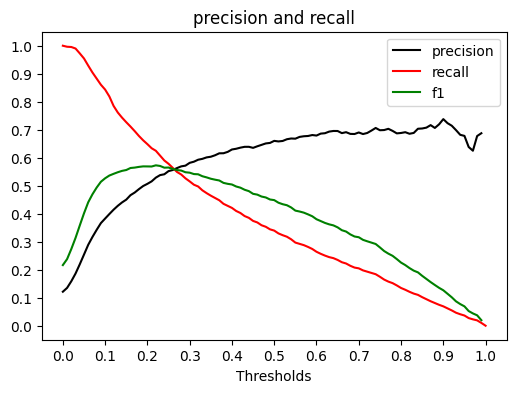

In [31]:
plt.figure(figsize=(6, 4))

plt.plot(df_scores.threshold, df_scores.precision, color='black', linestyle='solid', label='precision')
plt.plot(df_scores.threshold, df_scores.recall, color='red', linestyle='solid', label='recall')
plt.plot(df_scores.threshold, df_scores.f1, color='green', linestyle='solid', label='f1')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Thresholds')
plt.title('precision and recall')

# plt.savefig('04_fpr_tpr_plot.svg')

plt.show()

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.02
- 0.22
- 0.42
- 0.62

In [36]:
df_scores['f1'].max()

0.5728601252609603

In [39]:
df_scores.loc[df_scores['f1'] == 0.5728601252609603]


,threshold,precision,recall,f1
22,0.22,0.528913,0.624772,0.57286


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.26